In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re #wyrazenia regularne
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, ShuffleSplit, KFold, train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import scikitplot as skplt

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

import gc #smietnik

from datetime import datetime


/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Czyszczenie danych

In [9]:

def read_and_clean_data():

    train = pd.read_hdf('../input/train.car_price.h5')
    test = pd.read_hdf('../input/test.car_price.h5') #zbiór testowy bez odpowiedzi

    # braki danych
    train.fillna(-1, inplace = True)
    test.fillna(-1, inplace = True)

    # łączę oba zbiory - dalej pracuję na all_data
    all_data = pd.concat([train, test], axis = 0)

    # black list: tego w ogole nie chce analizowac 
    del_feats = ['breadcrumb','price_details']

    for feat in del_feats:
        if feat in all_data: del all_data[feat]

    ### laczenie odpowiadajacych sobie zmiennych

    lista_param_ANG_POL = [('param_first-registration', 'param_pierwsza-rejestracja'),
                           ('param_engine-code', 'param_kod-silnika'),
                            ('param_country-of-origin', 'param_kraj-pochodzenia'),
                            ('param_gearbox', 'param_skrzynia-biegów'),
                            ('param_service-record','param_serwisowany-w-aso'),
                            ('param_leasing-concession','param_leasing'),
                            ('param_color','param_kolor'),
                            ('param_financing-option','param_możliwość-finansowania'),
                            ('param_original-owner','param_pierwszy-właściciel'),
                            ('param_co2-emissions','param_emisja-co2'),
                            ('param_mileage', 'param_przebieg'),
                            ('param_vat-discount','param_vat-marża'), 
                            ('param_vat-free','param_faktura-vat'),                  
                            ('param_particle-filter','param_filtr-cząstek-stałych'),
                            ('param_make', 'param_marka-pojazdu'),
                            ('param_engine-power', 'param_moc'),
                            ('param_year','param_rok-produkcji'),
                            ('param_registered-in-poland','param_zarejestrowany-w-polsce'),
                            ('param_transmission','param_napęd'),   
                            ('param_version', 'param_wersja'),
                            ('param_fuel-type', 'param_rodzaj-paliwa'),
                            ('param_acrylic','param_akryl-(niemetalizowany)'),
                            ('param_damaged','param_uszkodzony'),
                            ('param_door-count','param_liczba-drzwi'),
                            ('param_nr-of-seats', 'param_liczba-miejsc'),
                            ('param_engine-capacity', 'param_pojemność-skokowa'),
                            ('param_pearl','param_perłowy'),
                            ('param_body-type','param_typ'),
                            ('param_monthly-payment-value', 'param_miesięczna-rata'),
                            ('param_metallic','param_metalik'),
                            ('param_no-accident', 'param_bezwypadkowy')
                ]


    for zmienna_ANG, zmienna_POL in lista_param_ANG_POL:
        all_data[zmienna_POL] = all_data.apply(lambda x: x[zmienna_POL] if x[zmienna_POL] != -1 else x[zmienna_ANG], axis = 1)
        del all_data[zmienna_ANG]
  
    ## konwersja danych + czyszczenie
        # liczby, ktore nie sa zapisane jako liczby
    all_data['param_rok-produkcji'] = all_data['param_rok-produkcji'].map(lambda x: int(x))
    all_data['param_liczba-miejsc'] = all_data['param_liczba-miejsc'].map(lambda x: int(x))
    all_data['param_liczba-pozostałych-rat']= all_data['param_liczba-pozostałych-rat'].map(lambda x: float(str(x).replace(',','.').replace(' ','')))

    # czyszczenie: param_moc, param_pojemność-skokowa, param_przebieg + cechy z PLN
    def get_param_value(val,ptrn_string_out, is_float = False):
        if val is None: return -1
        if val == -1: return -1

        val = re.sub(ptrn_string_out,'',str(val)).replace(' ','')

        if is_float: 
            val = float(val.replace(',','.'))
        else: 
            val = int(val)

        return val

    all_data['param_moc'] = all_data['param_moc'].map(lambda x: get_param_value(x,'KM|HP'))
    all_data['param_pojemność-skokowa'] = all_data['param_pojemność-skokowa'].map(lambda x: get_param_value(x,'cm3'))
    all_data['param_przebieg'] = all_data['param_przebieg'].map(lambda x: get_param_value(x,'km'))

    all_data['param_opłata-początkowa'] = all_data['param_opłata-początkowa'].map(lambda x: get_param_value(x,'PLN',True))
    all_data['param_miesięczna-rata'] = all_data['param_miesięczna-rata'].map(lambda x: get_param_value(x,'PLN',True))
    all_data['param_wartość-wykupu'] = all_data['param_wartość-wykupu'].map(lambda x: get_param_value(x,'PLN',True))

    ## wartosci odstajace - poprawianie bledow
    all_data['param_moc'].replace(543848,-1, inplace = True)
    all_data['param_pojemność-skokowa'].replace(3000218,-1, inplace = True)
    all_data['param_przebieg'].replace(14600690,-1, inplace = True)
    all_data['param_przebieg'].replace(9999999,-1, inplace = True)
    all_data['param_przebieg'].replace(7777777,-1, inplace = True)
    all_data['param_liczba-pozostałych-rat'].replace(8926.0,-1, inplace = True)

    # normalizacja zmiennych ciaglych, ktore maja duze skosy
    all_data['param_moc_log'] = all_data['param_moc'].map(lambda x: -1 if x <= 0 else np.log(x))
    all_data['param_przebieg_log'] = all_data['param_przebieg'].map(lambda x: -1 if x <=0 else np.log(x))
    all_data['param_pojemność-skokowa_log'] = all_data['param_pojemność-skokowa'].map(lambda x: -10 if x<=0 else np.log(x/1000))

    
    # wyciaganie dat 
    lista_miesiace = [
        ('styczeń|January|stycznia', '-01-'),
        ('luty|February|lutego', '-02-'),
        ('marzec|March|marca', '-03-'),
        ('kwiecień|April|kwietnia', '-04-'),
        ('maj|May|maja', '-05-'),
        ('czerwiec|June|czerwca', '-06-'),
        ('lipiec|July|lipca', '-07-'),
        ('sierpień|August|sierpnia', '-08-'),
        ('wrzesień|September|września', '-09-'),
        ('październik|October|pażdziernika', '-10-'),
        ('listopad|November|listopada', '-11-'),
        ('grudzień|December|grudnia','-12-')
    ]

    def get_date(val):
        if val is None: return -1
        if val == -1: return -1

        for miesiac, nr in lista_miesiace:
            if re.findall(miesiac, val) != []:
                date_str = re.sub(miesiac, nr, val).replace(' ','')
                break
        try:
            date_obj = datetime.strptime(date_str,'%d-%m-%Y').date()
        except:
            date_obj = datetime.strptime(date_str,'-%m-%Y').date()
        return date_obj

    def get_date_and_time(val):
        if val is None: return -1
        if val == -1: return -1

        for miesiac, nr in lista_miesiace:
            if re.findall(miesiac, val) != []:
                date_str = re.sub(miesiac, nr, val).replace(' ','')
                break
        date_obj = datetime.strptime(date_str,'%H:%M,%d-%m-%Y')
        return date_obj

    all_data['data_pierwsza_rejestracja']=all_data['param_pierwsza-rejestracja'].map(lambda x: get_date(x))
    all_data['data_created_at']=all_data['created_at'].map(lambda x: get_date_and_time(x))

    del all_data['param_pierwsza-rejestracja']
    del all_data['created_at']

    # wyciaganie nazwy wojewodztwa

    lista_wojewodztwa = [
            ('mazowieckie|warszawa|józefów\,','mazowieckie'),
            ('małopolskie|kraków','małopolskie'),
            ('podkarpackie','podkarpackie'), 
            ('zachodnio-pomorskie| szczecin\,| police\,','zachodnio-pomorskie'),
            ('kujawsko-pomorskie','kujawsko-pomorskie'),
            ('pomorskie|gdynia\,| gdansk\,| gdańsk\,| sopot\,','pomorskie'),
            ('wielkopolskie| poznań| rawicz\,|rawicz--','wielkopolskie'),
            ('warmińsko-mazurskie','warmińsko-mazurskie'),
            ('podlaskie| białystok\,','podlaskie'),
            ('łódzkie| łódź\,','łódzkie'),
            ('śląskie| gliwice\,|katowice\,|częstochowa| będzin\,|43-190 mikołów\,| zawiercie\,| łaziska górne|chełm śląski\,| bieruń\,| czeladź\,| imielin\,| orzesze\,','śląskie'),
            ('dolnośląskie| wrocław\,|jelenia góra\,| oleśnica\,|bogatynia\,','dolnośląskie'),
            ('opolskie|kędzierzyn-koźle','opolskie'),
            ('lubuskie','lubuskie'),
            ('lubelskie','lubelskie'),
            ('świętokrzyskie','świętokrzyskie')
    ]

    def get_wojewodztwo(tekst):
        if tekst is None: return -1
        if tekst == -1: return -1
        
        wojewodztwo = -1
        for woj_pattern, woj_name in lista_wojewodztwa:
            if re.findall(woj_pattern, str(tekst).lower())!=[]:
                wojewodztwo = woj_name
                break
        return wojewodztwo
 
    all_data['seller_wojewodztwo'] = all_data['seller_address'].map(lambda x: get_wojewodztwo(x))

    # wyciaganie nazwy kraju
    
    lista_kraje = [
        ('\(polska\)', 'Polska'),
        ('\(czechy\)', 'Czechy'),
        ('\(francja\)', 'Francja'),
        ('mukaczewo', 'Ukraina'),
        ('\(słowacja\)', 'Słowacja'),
        ('irlandia', 'Irlandia'),
        ('\(hiszpania\)', 'Hiszpania'),
        (' belgia', 'Belgia'),
        ('berlin| bayern| dortmund|nordrhein-westfalen|niedersachsen', 'Niemcy'),
        ('manchester', 'Wielka Brytania'),
        ('vorarlberg','Austria')
    ]


    def get_kraj(tekst, woj):
        if woj != -1: return 'Polska'
        if tekst is None: return -1
        if tekst == -1: return -1

        kraj = -1
        for kraj_pattern, kraj_name in lista_kraje:
            if re.findall(kraj_pattern, str(tekst).lower())!=[]:
                kraj = kraj_name
                break
        return kraj

    all_data['seller_kraj'] = all_data.apply(lambda x: get_kraj(x['seller_address'],x['seller_wojewodztwo']), axis = 1)


    # wyciaganie kodu pocztoweg
    
    def get_kod_pocztowy(row):
        tekst=str(row)
        ptrn_kod_poczt ='[0-9]{2}-[0-9]{3}'
        res = re.findall(ptrn_kod_poczt,tekst)
        if res == []:
            return -1
        else:
            return res[0]

    all_data['seller_kod_pocztowy']= all_data['seller_address'].map(lambda x: get_kod_pocztowy(x))
    
    return all_data


all_data = read_and_clean_data()

## Target variable - logarytm
w tym miejscu na potrzeby FE (wykresy do weryfikacji hipotez). dalej i tak sobie to przeliczam ponownie

In [33]:
PRICE_LOG_OFFSET = 600
all_data['price_value_log'] = all_data['price_value'].map(lambda x: None if x is None else np.log(x+PRICE_LOG_OFFSET))

## FEATURE ENGINEERING

In [34]:
### TU BEDE ZBIERAC NOWE CECHY:
my_features = []

###############################3

## podział marek na 4 grupy wg MEDIANY i wg SREDNIEJ ceny danej marki

median_price_vs_marka = all_data[~all_data.price_value.isnull()][['price_value_log','param_marka-pojazdu']]\
        .groupby('param_marka-pojazdu').median()

mean_price_vs_marka = all_data[~all_data.price_value.isnull()][['price_value_log','param_marka-pojazdu']]\
        .groupby('param_marka-pojazdu').mean()

median_perc_25, median_perc_50, median_perc_75 = np.percentile(median_price_vs_marka, 25), np.percentile(median_price_vs_marka, 50), np.percentile(median_price_vs_marka, 75)
mean_perc_25, mean_perc_50, mean_perc_75 = np.percentile(mean_price_vs_marka, 25), np.percentile(mean_price_vs_marka, 50), np.percentile(mean_price_vs_marka, 75)
    

def grupuj_marka_wg_ceny(marka, df_price, perc_25, perc_50, perc_75):
    try:
        cena_marki = df_price.loc[marka][0]
        if cena_marki <= perc_25:
            res = 'najtansze'
        elif cena_marki <= perc_50:
            res = 'tansze'
        elif cena_marki <= perc_75:
            res = 'drozsze'
        else:
            res = 'najdrozsze'
    except: res = 'brak info'
    return res


all_data['group_marka_median_price'] = all_data['param_marka-pojazdu']\
                                        .map(lambda x: grupuj_marka_wg_ceny(x, median_price_vs_marka,median_perc_25, median_perc_50, median_perc_75))
all_data['group_marka_mean_price'] = all_data['param_marka-pojazdu']\
                                        .map(lambda x: grupuj_marka_wg_ceny(x, mean_price_vs_marka,mean_perc_25, mean_perc_50, mean_perc_75))

my_features.append('group_marka_median_price')
my_features.append('group_marka_mean_price')

###
def cena_marki(marka, df_price):
    try:
        res = df_price.loc[marka][0]
    except: res = -1
    return res

all_data['price_median_marka'] = all_data['param_marka-pojazdu'].map(lambda x: cena_marki(x, median_price_vs_marka))
all_data['price_mean_marka'] = all_data['param_marka-pojazdu'].map(lambda x: cena_marki(x, mean_price_vs_marka))

my_features.append('price_median_marka')
my_features.append('price_mean_marka')

## ANALOGICZNIE JAK WYZEJ, ALE GRUPOWANIE ROZSZERZONE O ROCZNIK

median_price_vs_marka_i_rocznik = all_data[~all_data.price_value_log.isnull()][['param_marka-pojazdu','param_rok-produkcji','price_value_log']]\
                                  .groupby(['param_marka-pojazdu','param_rok-produkcji']).median()

mean_price_vs_marka_i_rocznik = all_data[~all_data.price_value_log.isnull()][['param_marka-pojazdu','param_rok-produkcji','price_value_log']]\
                                  .groupby(['param_marka-pojazdu','param_rok-produkcji']).mean()


median_perc_25, median_perc_50, median_perc_75 = np.percentile(median_price_vs_marka_i_rocznik, 25),\
                                                 np.percentile(median_price_vs_marka_i_rocznik, 50),\
                                                 np.percentile(median_price_vs_marka_i_rocznik, 75)
   

def grupuj_marka_i_rok_wg_ceny(marka, rok, df_price, perc_25, perc_50, perc_75):
    try:
        cena_marki = df_price.loc[marka].loc[rok][0]
        if cena_marki <= perc_25:
            res = 'najtansze'
        elif cena_marki <= perc_50:
            res = 'tansze'
        elif cena_marki <= perc_75:
            res = 'drozsze'
        else:
            res = 'najdrozsze'
    except: res = 'brak info'
    return res

def cena_marka_rocznik(marka,rok, df_price):
    try:
        res = df_price.loc[marka].loc[rok][0]
    except: res = -1
    return res


all_data['group_marka_rocznik_median_price'] = all_data\
                                        .apply(lambda x: grupuj_marka_i_rok_wg_ceny(x['param_marka-pojazdu'],x['param_rok-produkcji'],median_price_vs_marka_i_rocznik,\
                                                                                    median_perc_25, median_perc_50, median_perc_75), axis = 1)
my_features.append('group_marka_rocznik_median_price')

all_data['price_median_marka_rocznik'] = all_data.apply(lambda x: cena_marka_rocznik(x['param_marka-pojazdu'],x['param_rok-produkcji'],median_price_vs_marka_i_rocznik),axis=1)
all_data['price_mean_marka_rocznik'] = all_data.apply(lambda x: cena_marka_rocznik(x['param_marka-pojazdu'],x['param_rok-produkcji'],mean_price_vs_marka_i_rocznik),axis=1)

my_features.append('price_median_marka_rocznik')
my_features.append('price_mean_marka_rocznik')


##########################
## GRUPOWANIE WARTOSCI POJEDYNCZYCH CECH

# kraj pochodzenia: Polska, Niemcy, -1, inne
all_data['group_kraj_pochodzenia'] = all_data['param_kraj-pochodzenia'].map(lambda x: x if x in ["Polska", "Niemcy",-1] else "inne") 

my_features.append('group_kraj_pochodzenia')

#rok produkcji
def gr_rok_produkcji(n): 
    if n == -1: return -1
    
    if n < 1990: 
        res = "<1990" 
    elif (1990 <= n < 2000):
        res = "1990-1999"
    elif (2000 <= n < 2010):
        res = "2000-2009"
    else:
        res = "2010 +"
    return res

#rok produkcji - wersja 2
def gr_rok_produkcji_2(n): 
    if n <= 2005: 
        res = "<2005_i_NA"
    elif (2005< n <= 2009):
        res = "2006-2009"
    elif (2009< n <= 2014):
        res = "2010-2014"
    else:
        res = "2015-2018"
    return res

#rok produkcji - wersja 3
def gr_rok_produkcji_3(n): 
    if n < 2000: 
        res = "<2000_i_NA" 
    elif (2000 <= n < 2010):
        res = "2000-2009"
    elif (2010<= n < 2017):
        res = "2010-2016"
    else:
        res = "2017-2018"
    return res


#rok produkcji - wersja 4
def gr_rok_produkcji_4(n): 
    if n < 2010: 
        res = "do_1999_i_NA" 
    elif (2010 <= n < 2017):
        res = "2010-2016"
    else:
        res = "2017-2018"
    return res

all_data['group_rok_produkcji'] = all_data['param_rok-produkcji'].map(lambda x: gr_rok_produkcji(x))
all_data['group_rok_produkcji_2'] = all_data['param_rok-produkcji'].map(lambda x: gr_rok_produkcji_2(x))
all_data['group_rok_produkcji_3'] = all_data['param_rok-produkcji'].map(lambda x: gr_rok_produkcji_3(x))
all_data['group_rok_produkcji_4'] = all_data['param_rok-produkcji'].map(lambda x: gr_rok_produkcji_4(x))

my_features.append('group_rok_produkcji')
my_features.append('group_rok_produkcji_2')
my_features.append('group_rok_produkcji_3')
my_features.append('group_rok_produkcji_4')

##################

# SUMA FEATURES
bool_feats = [x for x in all_data.select_dtypes(include = np.bool).columns.values if x.startswith('feature')]
all_data['sum_features'] = all_data[bool_feats].sum(axis=1)

feats_lux = ['feature_czujniki-parkowania-przednie',
            'feature_bluetooth',
            'feature_łopatki-zmiany-biegów',
            'feature_dach-panoramiczny',
            'feature_podgrzewane-tylne-siedzenia',
            'feature_podgrzewane-przednie-siedzenia',
            'feature_tapicerka-skórzana',
            'feature_hud-(wyświetlacz-przezierny)',
            'feature_tuner-tv',
            'feature_asystent-parkowania',
            'feature_asystent-pasa-ruchu',
            'feature_regulowane-zawieszenie',
            'feature_światła-led'
            ]

all_data['sum_features_lux'] = all_data[feats_lux].sum(axis=1)

my_features.append('sum_features')
my_features.append('sum_features_lux')

# SUMA BRAKOW DANYCH (wartosci -1) w zmiennych param_xxx
param_feats = [x for x in all_data.select_dtypes(include = np.object).columns.values if x.startswith('param')]
all_data['sum_param_NA'] = all_data[param_feats].sum(axis=1)

my_features.append('sum_param_NA') 

##################

# grupowanie kolorow
def grupuj_kolory(kolor):
    if kolor in ['Czarny', 'Srebrny', 'Szary', 'Biały', 'Inny kolor']:
        res = kolor 
    else: res = 'pozostałe'
    
    return res

all_data['group_kolor']=all_data['param_kolor'].map(lambda x: grupuj_kolory(x)).values

my_features.append('group_kolor')

# kombinacja cech: seller_type + param_oferta-od
all_data['comb_seller_type_oferta_od']= all_data['seller_type'] + all_data['param_oferta-od']

my_features.append('comb_seller_type_oferta_od')

#################

# ZMIENNE TYPU: JEST/ NIE MA

all_data['is_kod_pocztowy'] = all_data['seller_kod_pocztowy'].map(lambda x: False if x == -1 else True)
all_data['is_kod_silnika'] = all_data['param_kod-silnika'].map(lambda x: False if x == -1 else True)

all_data['is_param_vin']=all_data['param_vin'].map(lambda x: False if x == -1 else True)
my_features.append('is_param_vin')


my_features.append('is_kod_pocztowy')
my_features.append('is_kod_silnika')


###### OPERACJE NA DATACH

all_data['ROK_pierwsza_rejestracja'] = all_data['data_pierwsza_rejestracja'].map(lambda x: -1 if x == -1 else int(x.year))
all_data['MIESIAC_pierwsza_rejestracja'] = all_data['data_pierwsza_rejestracja'].map(lambda x: -1 if x == -1 else int(x.month))

all_data['ROK_created_at'] = all_data['data_created_at'].map(lambda x: -1 if x == -1 else int(x.year))
all_data['MIESIAC_created_at'] = all_data['data_created_at'].map(lambda x: -1 if x == -1 else int(x.month))
all_data['DZIENTYG_created_at'] = all_data['data_created_at'].map(lambda x: -1 if x == -1 else int(x.weekday()))

my_features.append('ROK_pierwsza_rejestracja')
my_features.append('MIESIAC_pierwsza_rejestracja')
my_features.append('ROK_created_at')
my_features.append('MIESIAC_created_at')
my_features.append('DZIENTYG_created_at')

### jak dlugo wisi ogloszenie?
# = date_last - data_created_at 

DATE_last = all_data[all_data['data_created_at']!=-1]['data_created_at'].values.max()
def roznica_dni(data1, data2):
    if (data1 == -1) | (data2 == -1): return -1
    return (data2 - data1).days + 1
    
all_data['dni_ogloszenie_aktywne'] = all_data['data_created_at'].map(lambda x: roznica_dni(x, DATE_last))
my_features.append('dni_ogloszenie_aktywne')

### czas od rejestracji do sprzedazy
def roznica_dni_2(data_czas, data):
    if (data_czas == -1) | (data == -1): return -1
    return (data_czas.date() - data).days + 1
    
all_data['dni_rejestracja_sprzedaz'] = all_data.apply(lambda x: roznica_dni_2(x['data_created_at'], x['data_pierwsza_rejestracja']) , axis =1)
my_features.append('dni_rejestracja_sprzedaz')

### czas od roku produkcji do sprzedazy
def roznica_dni_3(data, rok):
    if (data == -1) | (rok == -1): return -1
    delta = data - datetime.strptime('{0}-01-01'.format(rok), '%Y-%m-%d')
    return delta.days

all_data['dni_rok_produkcji_sprzedaz'] = all_data.apply(lambda x: roznica_dni_3(x['data_created_at'], x['param_rok-produkcji']) , axis =1)
my_features.append('dni_rok_produkcji_sprzedaz')

########################
## SREDNI ROCZNY PRZEBIEG
def roznica_dat_lata(data_czas, rok):
    if (data_czas == -1) | (rok == -1): return -1
    delta = data_czas - datetime.strptime('{0}-01-01'.format(rok), '%Y-%m-%d')
    return delta.days/365

all_data['roczny_przebieg'] = all_data.apply(lambda x: x['param_przebieg']/roznica_dat_lata(x['data_created_at'],x['param_rok-produkcji']),axis=1) 
all_data['roczny_przebieg'] = all_data['roczny_przebieg'].map(lambda x: -1 if x<0 else x)

all_data['roczny_przebieg_log'] = all_data['roczny_przebieg'].map(lambda x: -1 if x <=0 else np.log(x))

my_features.append('roczny_przebieg')
my_features.append('roczny_przebieg_log')

#####################################
# operacje na dostepnych cenach
def leasing_koszt(oplata_pocz, liczba_rat, wys_raty, wykup):
    if (liczba_rat == -1) | (wys_raty == -1): return -1
    koszt = max(oplata_pocz,0) + max(wykup,0) + liczba_rat * wys_raty
    return koszt

all_data['leasing_koszt'] = all_data.apply(lambda x: leasing_koszt(x['param_opłata-początkowa'],\
                                                                   x['param_liczba-pozostałych-rat'],\
                                                                   x['param_miesięczna-rata'],\
                                                                   x['param_wartość-wykupu']), axis=1)
my_features.append('leasing_koszt')


#########################
## KOD SILNIKA - RANKINGOWANIE CZESTOSCI

counts_kod_silnika = pd.DataFrame(all_data['param_kod-silnika'].value_counts())
counts_kod_silnika['ranking'] = counts_kod_silnika.rank(method = 'dense')

all_data['ranking_kod_silnika']=all_data['param_kod-silnika'].map(lambda x: counts_kod_silnika.loc[x]['ranking'])

my_features.append('ranking_kod_silnika')

## MARKI z DANEGO ROCZNIKA - RANKING CZESTOSCI
# (PEWNIE TO SIE DA ZROBIC JEDNA METODA, ALE NIE UMIEM...)
count_marka_vs_rok = all_data[['param_rok-produkcji','param_marka-pojazdu']].groupby('param_rok-produkcji')['param_marka-pojazdu'].value_counts()

df_temp = pd.DataFrame(all_data[['car_id','param_rok-produkcji','param_marka-pojazdu']].values,
                      columns = ['car_id','rok','marka'])
df_temp['values'] = df_temp.apply(lambda x: count_marka_vs_rok.loc[x['rok']].loc[x['marka']] , axis = 1)

all_data['ranking_marka_vs_rok'] = df_temp[['rok','marka','values']].groupby(['rok'])['values'].rank(method='dense').values
my_features.append('ranking_marka_vs_rok')

del df_temp
del count_marka_vs_rok

## ROCZNIKI DANEJ MARKI - RANKING CZESTOSCI

count_rok_vs_marka = all_data[['param_rok-produkcji','param_marka-pojazdu']].groupby('param_marka-pojazdu')['param_rok-produkcji'].value_counts()

df_temp = pd.DataFrame(all_data[['car_id','param_rok-produkcji','param_marka-pojazdu']].values,
                      columns = ['car_id','rok','marka'])
df_temp['values'] = df_temp.apply(lambda x: count_rok_vs_marka.loc[x['marka']].loc[x['rok']] , axis = 1)

all_data['ranking_rocznik_vs_marka'] = df_temp[['rok','marka','values']].groupby(['marka'])['values'].rank(method='dense').values
my_features.append('ranking_rocznik_vs_marka')

del df_temp
del count_rok_vs_marka

all_data['is_param_wersja']=all_data['param_wersja'].map(lambda x: False if x == -1 else True)
all_data['is_param_model']=all_data['param_model'].map(lambda x: False if x == -1 else True)

my_features.append('is_param_wersja')
my_features.append('is_param_model')

all_data['comb_model_marka'] = all_data.apply(lambda x: str(x['param_marka-pojazdu']) + str(x['param_model']),axis = 1)

my_features.append('comb_model_marka')


In [35]:
my_features

['group_marka_median_price',
 'group_marka_mean_price',
 'price_median_marka',
 'price_mean_marka',
 'group_marka_rocznik_median_price',
 'price_median_marka_rocznik',
 'price_mean_marka_rocznik',
 'group_kraj_pochodzenia',
 'group_rok_produkcji',
 'group_rok_produkcji_2',
 'group_rok_produkcji_3',
 'group_rok_produkcji_4',
 'sum_features',
 'sum_features_lux',
 'sum_param_NA',
 'group_kolor',
 'comb_seller_type_oferta_od',
 'is_param_vin',
 'is_kod_pocztowy',
 'is_kod_silnika',
 'ROK_pierwsza_rejestracja',
 'MIESIAC_pierwsza_rejestracja',
 'ROK_created_at',
 'MIESIAC_created_at',
 'DZIENTYG_created_at',
 'dni_ogloszenie_aktywne',
 'dni_rejestracja_sprzedaz',
 'dni_rok_produkcji_sprzedaz',
 'roczny_przebieg',
 'roczny_przebieg_log',
 'leasing_koszt',
 'ranking_kod_silnika',
 'ranking_marka_vs_rok',
 'ranking_rocznik_vs_marka',
 'is_param_wersja',
 'is_param_model',
 'comb_model_marka']

## Faktoryzacja zmiennych

In [36]:
cat_feats = all_data.select_dtypes(include = np.object).columns
for cat_f in cat_feats:
    all_data['{0}_cat'.format(cat_f)]=pd.factorize(all_data[cat_f])[0]
    if cat_f in my_features:
        my_features.append('{0}_cat'.format(cat_f))
my_features = list(set(my_features))

# all_data.select_dtypes(include = np.number).columns

## Wizualizacje

In [57]:
def draw_plot_vs_price(x_var,type_chart, hue_var = None):
    my_plt = type_chart(x=x_var, y = 'price_value_log', hue = hue_var, data=all_data[~all_data.price_value.isnull()])
    return my_plt


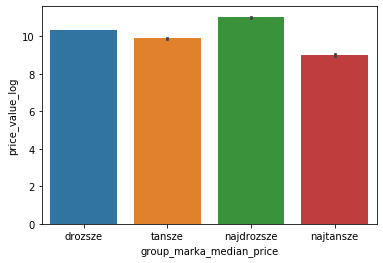

In [103]:
draw_plot_vs_price('group_marka_median_price',sns.barplot);

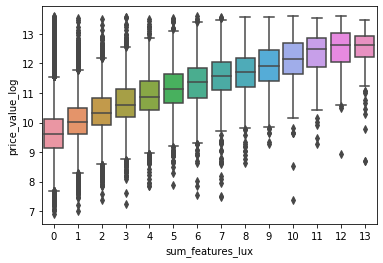

In [50]:
draw_plot_vs_price('sum_features_lux',sns.boxplot);

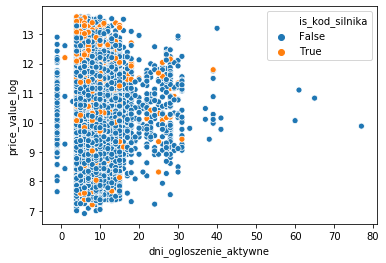

In [58]:
draw_plot_vs_price('dni_ogloszenie_aktywne',sns.scatterplot, hue_var = 'is_kod_silnika');

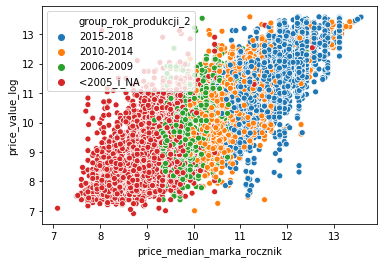

In [142]:
draw_plot_vs_price('price_median_marka_rocznik',sns.scatterplot, hue_var = 'group_rok_produkcji_2');

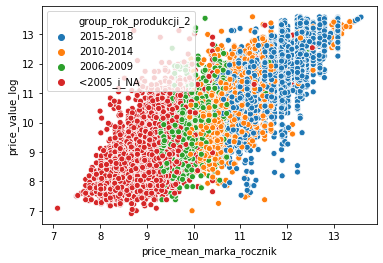

In [147]:
draw_plot_vs_price('price_mean_marka_rocznik',sns.scatterplot, hue_var = 'group_rok_produkcji_2');

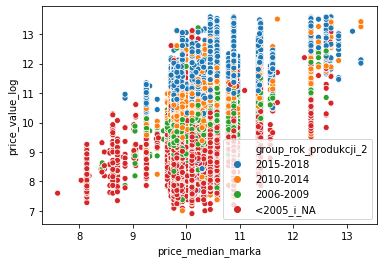

In [70]:
draw_plot_vs_price('price_median_marka',sns.scatterplot, hue_var = 'group_rok_produkcji_2');

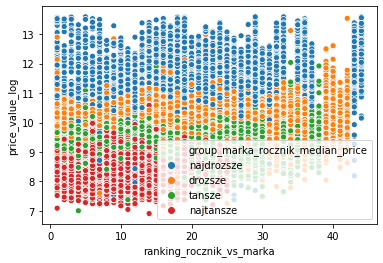

In [146]:
draw_plot_vs_price('ranking_rocznik_vs_marka', sns.scatterplot, hue_var = 'group_marka_rocznik_median_price');

# MODEL

In [37]:
##########################

# TRENOWANIE I WALIDACJA MODELU
def get_feats(feats):
    black_list = ['car_id','price_value', 'price_value_log',  'price_details_cat',
                  'seller_address_cat','seller_name_cat','param_vin_cat',
                  'data_pierwsza_rejestracja_cat','data_created_at_cat','seller_kod_pocztowy_cat']
    feats = [x for x in feats if x not in black_list]    
    return feats

def get_X(df, feats):
    return df[ get_feats(feats) ].values

def get_y(df, price_log_offset):
    df['price_value_log'] = df['price_value'].map(lambda x: np.log(x+price_log_offset))
    return df['price_value_log'].values

def get_models():

    xgb_params = {    
        'max_depth': 6, 
        'n_estimators': 100,
        'learning_rate': 0.2, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
    }

    ctb_params = {
        'n_estimators': 100, 
        'depth': 6, 
        'random_state':0, 
        'verbose': False
    }
    
    lgb_params = {
        'max_depth': 6, 
        'n_estimators': 100,
        'learning_rate': 0.2, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
    }
        
    
    return [
         ('lgb', lgb.LGBMRegressor(**lgb_params)),
         ('xgb', xgb.XGBRegressor(**xgb_params)),
         ('ctb', ctb.CatBoostRegressor(**ctb_params))
    ]

def run_cv(model, X, y, price_offset, folds=3, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds)
    
    scores = []
    kaggle_ind = 0
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train_log, y_test_log = y[train_idx], y[test_idx]

        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_test)

        global_min = y.min()
        y_pred_log[ y_pred_log < global_min] = global_min #nie schodzimy z prognozowana cena ponizej min w zbiorze
        
        y_test = np.exp(y_test_log)-price_offset
        y_pred = np.exp(y_pred_log)-price_offset
        
        score = success_metric(y_test, y_pred)
        scores.append( score )
              
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, price_offset, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        y = np.exp(y)-price_offset
        y_pred = np.exp(y_pred)-price_offset
        y_pred[ y_pred<0 ] = 0
        
        return mean_absolute_error(y, y_pred)
        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, feats, price_offset, plot_lc=False, folds=3, ylim=(0, 12000)):
    X, y  = get_X(train,feats), get_y(train, price_offset)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y,price_offset=price_offset, folds=folds)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y,price_offset=price_offset, ylim=ylim, cv=folds)
        plt.show();


### Zbiór train i test 

In [72]:
# wyluskanie z powrotem train i test z all_data
train = all_data [~all_data.price_value.isnull()]
test_kaggle = all_data [all_data.price_value.isnull()]

train_temp = train.sample(frac=0.1)

print(train.shape)
print(test_kaggle.shape)

# del all_data
# gc.collect()

(106494, 221)
(54122, 221)


# Wybór cech

In [60]:
# wszysciutkie dostepne
feats_all = train.select_dtypes(include=[np.number,np.bool]).columns
# cechy po czyszczeniu danych
feats_original = [x for x in feats_all if x not in my_features]
# moje - FE
feats_only_my = [x for x in feats_all if x in my_features]
# tylko feature_XXX
feats_features = [x for x in feats_all if x.startswith('feature')]
# tylko param_XXX
feats_param = [x for x in feats_all if x.startswith('param')]

########################
feats_important = ['param_rok-produkcji',
                   'param_marka-pojazdu_cat',
                   'feature_czujniki-parkowania-przednie','feature_światła-led','feature_bluetooth',
                   'param_przebieg_log','param_moc_log','param_pojemność-skokowa_log',
                   'seller_type_cat','param_faktura-vat_cat','param_leasing_cat',
                   'param_napęd_cat','param_typ_cat','param_skrzynia-biegów_cat','param_stan_cat',
                   'seller_wojewodztwo_cat','seller_kraj_cat','price_currency_cat'
                  ]

feats_1 = feats_important + feats_only_my



### Feature Importance: główne podzbiory cech
Próbka 10% danych

In [114]:
# ELI5 + feature importance plot
def fi_ocena(FEATS,model_indx=0):
    X, y = get_X(train_temp,FEATS), get_y(train_temp,600)

    model_name, model = get_models()[model_indx]
    model.fit(X,y)
    
    imp = PermutationImportance(model, random_state=0).fit(X,y)

    title='Feature Importance. {0}'.format(model_name)
    skplt.estimators.plot_feature_importances(model, feature_names=get_feats(FEATS), title=title, x_tick_rotation=90, figsize=(15, 5));
    res_eli5 = eli5.show_weights(imp, feature_names=get_feats(FEATS), top=30)
    return res_eli5


Weight,Feature
0.3658 ± 0.0128,price_mean_marka_rocznik
0.1138 ± 0.0026,price_median_marka_rocznik
0.0359 ± 0.0017,param_moc
0.0187 ± 0.0013,param_uszkodzony_cat
0.0161 ± 0.0003,param_przebieg
0.0149 ± 0.0004,param_typ_cat
0.0132 ± 0.0009,sum_features
0.0075 ± 0.0004,param_pojemność-skokowa
0.0063 ± 0.0003,param_moc_log
0.0061 ± 0.0002,dni_rok_produkcji_sprzedaz


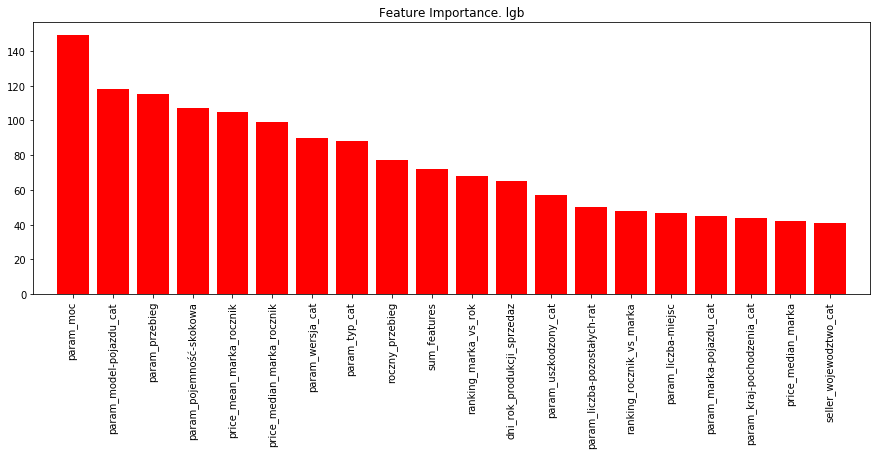

In [115]:
fi_ocena(feats_all,0)

Weight,Feature
0.8366 ± 0.0147,param_rok-produkcji
0.0986 ± 0.0025,param_moc
0.0411 ± 0.0008,param_przebieg
0.0346 ± 0.0018,param_marka-pojazdu_cat
0.0250 ± 0.0007,param_typ_cat
0.0198 ± 0.0009,param_uszkodzony_cat
0.0184 ± 0.0010,param_pojemność-skokowa
0.0128 ± 0.0010,param_napęd_cat
0.0111 ± 0.0006,param_model-pojazdu_cat
0.0087 ± 0.0004,param_skrzynia-biegów_cat


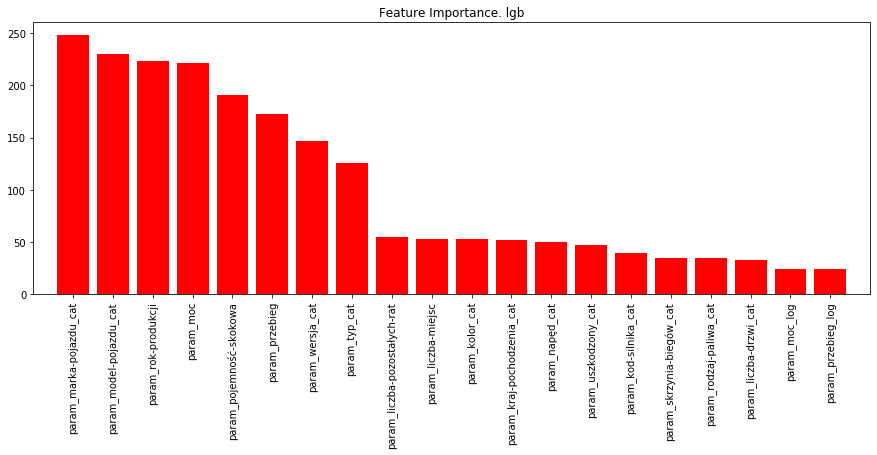

In [116]:
fi_ocena(feats_param,0)

Weight,Feature
0.1252 ± 0.0078,feature_poduszka-powietrzna-kierowcy
0.0670 ± 0.0136,feature_tapicerka-welurowa
0.0552 ± 0.0046,feature_światła-led
0.0452 ± 0.0022,feature_bluetooth
0.0400 ± 0.0039,feature_centralny-zamek
0.0388 ± 0.0019,feature_wspomaganie-kierownicy
0.0326 ± 0.0031,feature_kamera-cofania
0.0312 ± 0.0022,feature_abs
0.0304 ± 0.0030,feature_czujniki-parkowania-przednie
0.0258 ± 0.0026,feature_system-start-stop


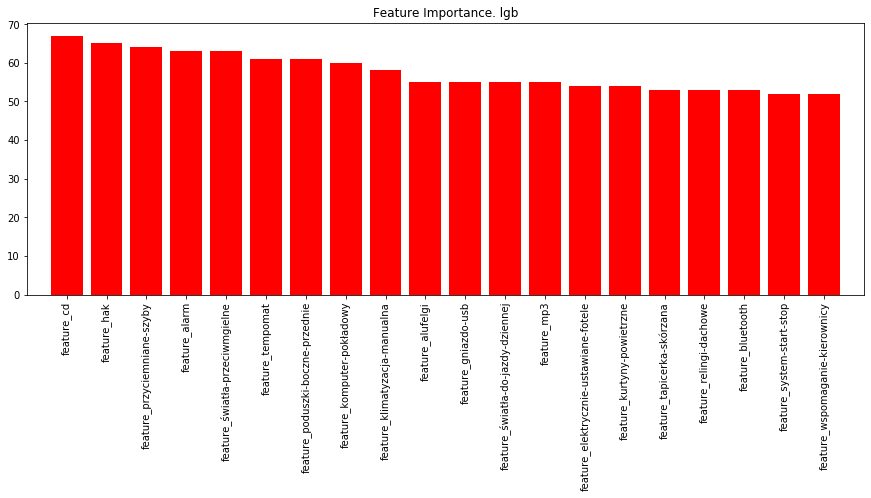

In [117]:
fi_ocena(feats_features,0)

Weight,Feature
0.3087 ± 0.0074,price_mean_marka_rocznik
0.2978 ± 0.0098,price_median_marka_rocznik
0.0558 ± 0.0011,sum_features_lux
0.0440 ± 0.0010,sum_features
0.0335 ± 0.0027,roczny_przebieg
0.0187 ± 0.0009,dni_rok_produkcji_sprzedaz
0.0131 ± 0.0014,group_kraj_pochodzenia_cat
0.0072 ± 0.0008,ranking_kod_silnika
0.0066 ± 0.0004,comb_seller_type_oferta_od_cat
0.0046 ± 0.0005,price_mean_marka


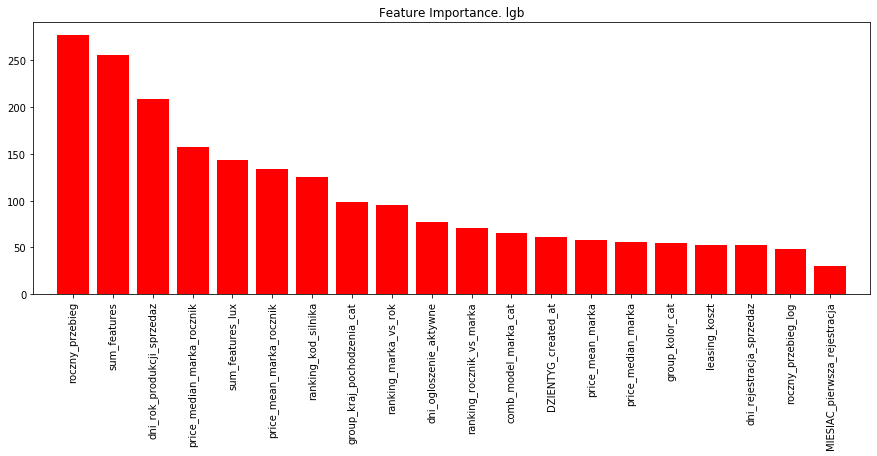

In [118]:
fi_ocena(feats_only_my,0)

Weight,Feature
0.2806 ± 0.0050,price_mean_marka_rocznik
0.0981 ± 0.0029,price_median_marka_rocznik
0.0827 ± 0.0034,sum_features_lux
0.0805 ± 0.0027,group_marka_rocznik_median_price_cat
0.0606 ± 0.0016,sum_features
0.0231 ± 0.0012,roczny_przebieg_log
0.0184 ± 0.0011,dni_rok_produkcji_sprzedaz
0.0138 ± 0.0006,group_kraj_pochodzenia_cat
0.0090 ± 0.0007,roczny_przebieg
0.0070 ± 0.0007,ranking_kod_silnika


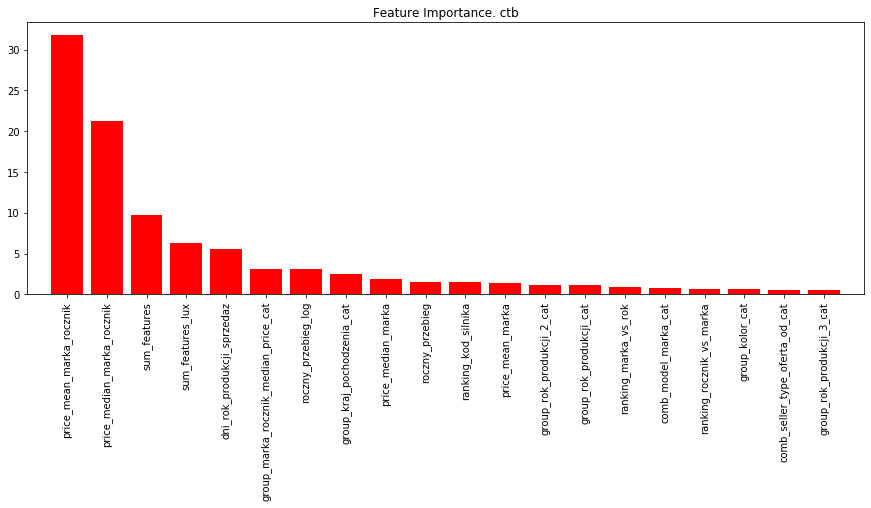

In [121]:
fi_ocena(feats_only_my,2)

### Feature importance: wybór najistotniejszych cech
według ELI5, na podst. LGBoost - warto byłoby zróżnicować to dla poszczególnych modeli jak sądzę

In [122]:
####################
## wybor na podst. feature importance - LGB
fi_features = [
'feature_bluetooth',
'feature_poduszka-powietrzna-kierowcy',
'feature_tapicerka-welurowa',
'feature_wspomaganie-kierownicy',
'feature_światła-led',
'feature_centralny-zamek',
'feature_system-start-stop',
'feature_kamera-cofania',
'feature_światła-do-jazdy-dziennej',
'feature_elektryczne-szyby-przednie',
'feature_czujniki-parkowania-przednie',
'feature_gniazdo-usb',
'feature_asr-(kontrola-trakcji)',
'feature_cd',
'feature_radio-fabryczne',
'feature_klimatyzacja-dwustrefowa',
'feature_isofix',
'feature_tempomat',
'feature_alufelgi',
'feature_czujniki-parkowania-tylne',
'feature_łopatki-zmiany-biegów',
'feature_immobilizer',
'feature_nawigacja-gps',
'feature_radio-niefabryczne',
'feature_asystent-pasa-ruchu',
'feature_gniazdo-aux',
'feature_esp-(stabilizacja-toru-jazdy)',
'feature_światła-przeciwmgielne',
'feature_komputer-pokładowy',
'feature_poduszka-powietrzna-pasażera'    
]

fi_param = [
'param_rok-produkcji',
'param_moc',
'param_marka-pojazdu_cat',
'param_przebieg',
'param_typ_cat',
'param_uszkodzony_cat',
'param_pojemność-skokowa',
'param_napęd_cat',
'param_model-pojazdu_cat',
'param_wersja_cat',
'param_skrzynia-biegów_cat',
'param_kod-silnika_cat',
'param_liczba-miejsc',
'param_kierownica-po-prawej-(anglik)_cat',
'param_bezwypadkowy_cat',
'param_kolor_cat',
'param_kraj-pochodzenia_cat',
'param_liczba-drzwi_cat',
'param_pojemność-skokowa_log',
'param_oferta-od_cat',
'param_rodzaj-paliwa_cat',
'param_serwisowany-w-aso_cat',
'param_przebieg_log',
'param_opłata-początkowa',
'param_zarejestrowany-w-polsce_cat',
'param_liczba-pozostałych-rat',
'param_vat-marża_cat',
'param_możliwość-finansowania_cat',
'param_moc_log',
'param_metalik_cat'
]

fi_only_my = [
'price_mean_marka_rocznik',
'price_median_marka_rocznik',
'sum_features_lux',
'sum_features',
'roczny_przebieg',
'dni_rok_produkcji_sprzedaz',
'group_kraj_pochodzenia_cat',
'ranking_kod_silnika',
'group_kolor_cat',
'ranking_rocznik_vs_marka',
'is_kod_silnika',
'price_median_marka',
'ranking_marka_vs_rok',
'comb_model_marka_cat',
'is_kod_pocztowy',
'price_mean_marka',
'dni_ogloszenie_aktywne',
'dni_rejestracja_sprzedaz',
'is_param_wersja',
'is_param_vin',
'MIESIAC_pierwsza_rejestracja',
'DZIENTYG_created_at',
'ROK_pierwsza_rejestracja',
'comb_seller_type_oferta_od_cat',
'roczny_przebieg_log',
'group_marka_median_price_cat',
'leasing_koszt',
'group_marka_mean_price_cat',
'MIESIAC_created_at',
'group_rok_produkcji_2_cat'    
]

###############

feats_fi_all = fi_features + fi_param + fi_only_my
feats_fi_all_2 = feats_fi_all + ['group_marka_rocznik_median_price_cat'] #ten parametr pojawia sie w ELI5 w catboost
feats_fi_1 = fi_features[:13] + fi_param + fi_only_my

### Trenowanie + walidacja: szybkie porównanie różnych podzbiorów
Próbka 10%

In [73]:
print(train_temp.shape)

(10649, 221)


In [74]:
## PUNKT WYJSCIA : wszystkie cechy modelu
run(train_temp,feats_original,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8408.571209298494 +/-282.1781455960528
[xgb]: 8712.14486361306 +/-494.07897029380865
[ctb]: 8497.144346002047 +/-397.0639287951658


In [75]:
## Wszystkie modelu + moje 
run(train_temp,feats_all,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8045.384450300923 +/-270.6619506585273
[xgb]: 8051.374071940631 +/-280.3794064416555
[ctb]: 8124.051737000674 +/-329.2609443650346


In [76]:
## Tylko moje 
run(train_temp,feats_only_my,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 12547.522036639815 +/-503.66982423834014
[xgb]: 12927.730110967857 +/-372.698263521723
[ctb]: 12473.763489265073 +/-316.89471041971063


In [77]:
## Tylko features_XXX
run(train_temp,feats_features,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 20622.1933004204 +/-623.2629136839179
[xgb]: 21178.43008490126 +/-654.13461538105
[ctb]: 20579.378711402907 +/-701.1422892258882


In [78]:
## Tylko param_XXX
run(train_temp,feats_param,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8473.52840975709 +/-327.00587185219695
[xgb]: 8849.104057870654 +/-381.9814172837618
[ctb]: 8711.434514522687 +/-427.5444759339001


In [79]:
run(train_temp,feats_1,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8814.801603365593 +/-177.21531553018357
[xgb]: 9015.638500000103 +/-269.6850465027222
[ctb]: 8877.52078898944 +/-340.6502967251212


In [80]:
run(train_temp,feats_fi_all,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8003.587621595576 +/-346.5094486596009
[xgb]: 8344.643834800841 +/-316.30198374217923
[ctb]: 8162.023504225101 +/-249.95123029128317


In [81]:
run(train_temp,feats_fi_1,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 8131.241842910371 +/-430.54669957908976
[xgb]: 8396.933650166768 +/-380.6081110903089
[ctb]: 8130.100827966152 +/-270.9997223955096


In [123]:
run(train_temp,feats_fi_all_2,price_offset=600,plot_lc=False, folds=3, ylim=None)

[lgb]: 7999.817011594628 +/-312.95342739199776
[xgb]: 8198.686860139656 +/-258.8310631585681
[ctb]: 8144.697789240948 +/-325.25003470441345


Weight,Feature
0.3611 ± 0.0042,price_mean_marka_rocznik
0.0776 ± 0.0011,price_median_marka_rocznik
0.0412 ± 0.0015,param_moc
0.0185 ± 0.0008,param_uszkodzony_cat
0.0169 ± 0.0005,param_przebieg
0.0143 ± 0.0006,param_typ_cat
0.0132 ± 0.0007,sum_features
0.0096 ± 0.0005,dni_rok_produkcji_sprzedaz
0.0086 ± 0.0005,param_pojemność-skokowa
0.0060 ± 0.0004,sum_features_lux


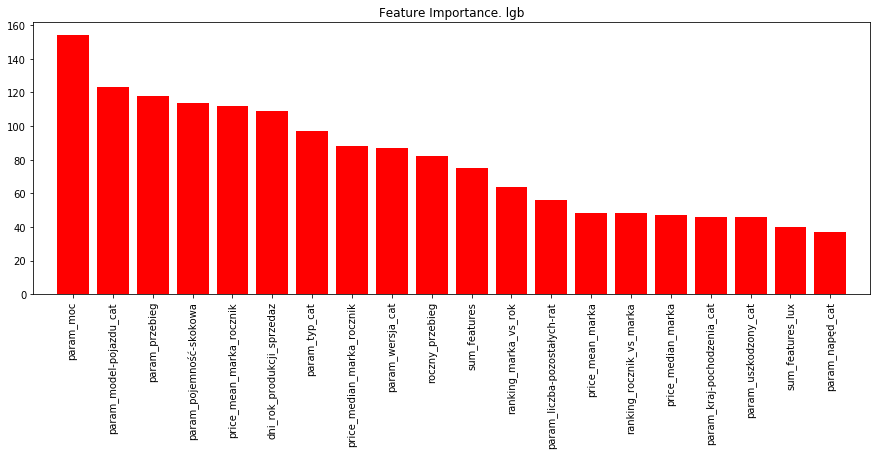

In [124]:
### zbior feats_fi_all_2 - ponowne spojrzenie na ELI5


fi_ocena(feats_fi_all_2,0)


## Trenowanie i walidacja finalnego modelu
Zbiór feats_fi_all_2

In [125]:
def fit_and_predict(model_cls, model_params, X_train, X_test, y_train):
    model = model_cls(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = np.exp(y_pred)-PRICE_LOG_OFFSET

    global_min = train.price_value.min()
    y_pred[ y_pred < global_min] = global_min
    
    return y_pred

In [131]:
FEATS = feats_fi_all_2
PRICE_LOG_OFFSET = 600

[lgb]: 7109.320753221749 +/-81.75204175858957


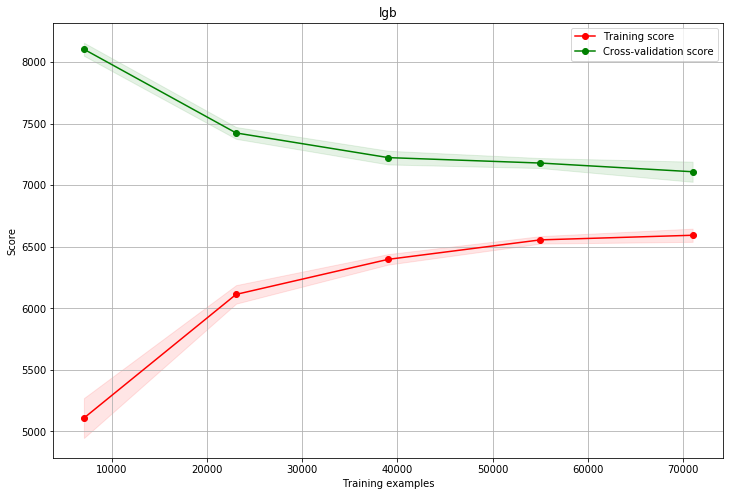

[xgb]: 7263.521300866459 +/-52.707846742400264


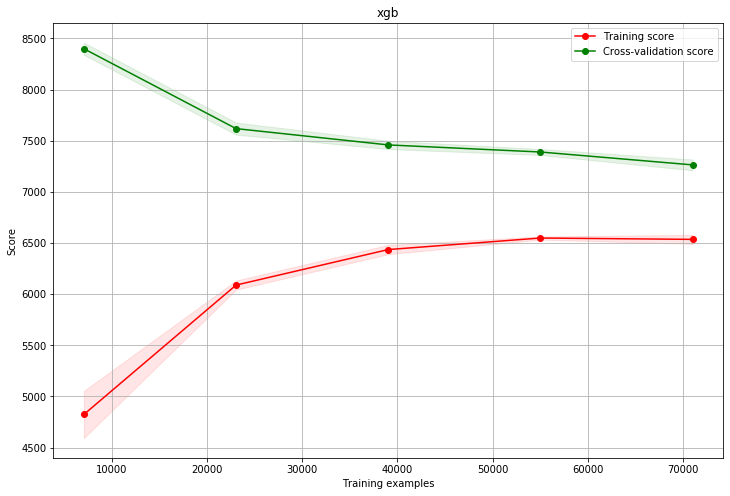

[ctb]: 7223.103352738105 +/-76.0293396719988


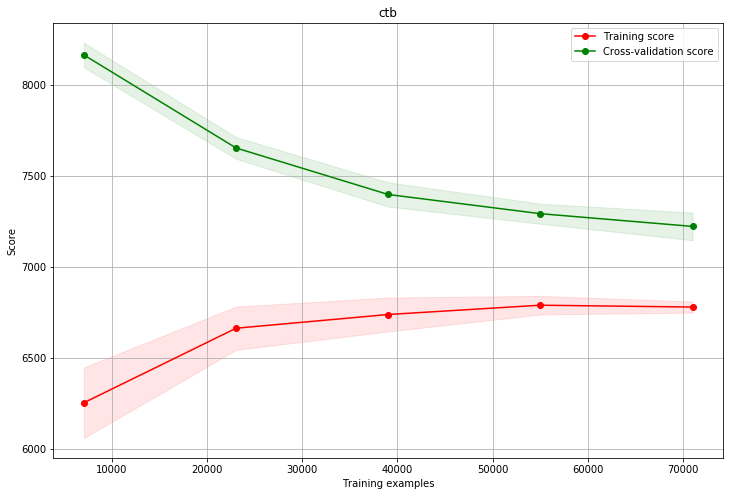

In [127]:
run(train,FEATS,price_offset=600,plot_lc=True, folds=3, ylim=None)

## Hyperopt

In [128]:
# train_hyperopt = train.sample(frac=0.5)
train_hyperopt = train

In [130]:
def objective_xgb(space):
    
    X, y = get_X(train_hyperopt,FEATS), get_y(train_hyperopt,int(space['PRICE_LOG_OFFSET']))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    xgb_params = {
        'max_depth': int(space['max_depth']), 
        'colsample_bytree': space['colsample_bytree'], 
        'learning_rate': space['learning_rate'], 
        'subsample': space['subsample'], 
        'random_state': int(space['random_state']),
        'n_estimators': 100, 
    }
    
    y_pred = fit_and_predict(model_cls=xgb.XGBRegressor, model_params=xgb_params, X_train=X_train, X_test=X_test, y_train=y_train)
    y_test = np.exp(y_test)-PRICE_LOG_OFFSET
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

def objective_ctb(space):
    
    X, y = get_X(train_hyperopt,FEATS), get_y(train_hyperopt,int(space['PRICE_LOG_OFFSET']))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    ctb_params = {
        'n_estimators': 100, 
        'depth': int(space['depth']), 
        'random_state':int(space['random_state']), 
        'verbose': False
    }
    
    y_pred = fit_and_predict(model_cls=ctb.CatBoostRegressor, model_params=ctb_params, X_train=X_train, X_test=X_test, y_train=y_train)
    y_test = np.exp(y_test)-PRICE_LOG_OFFSET
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

def objective_lgb(space):
    
    X, y = get_X(train_hyperopt,FEATS), get_y(train_hyperopt,int(space['PRICE_LOG_OFFSET']))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    lgb_params = {
        'max_depth': int(space['max_depth']), #
        'colsample_bytree': space['colsample_bytree'], #
        'learning_rate': space['learning_rate'], #
        'subsample': space['subsample'], #
        'random_state': int(space['random_state']),
        'n_estimators': 100, #
    }
    
    y_pred = fit_and_predict(model_cls=lgb.LGBMRegressor, model_params=lgb_params, X_train=X_train, X_test=X_test, y_train=y_train)
    y_test = np.exp(y_test)-PRICE_LOG_OFFSET
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

#############################3

space_xgb ={
    'PRICE_LOG_OFFSET': hp.quniform('x_PRICE_LOG_OFFSET', 0, 700, 100),
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50)
}

space_ctb = {
    'PRICE_LOG_OFFSET': hp.quniform('x_PRICE_LOG_OFFSET', 0, 700, 100),
    'depth': hp.quniform ('x_depth', 5, 16, 1), 
    'random_state':hp.quniform ('x_random_state', 0, 10000, 50), 
}

space_lgb = {
    'PRICE_LOG_OFFSET': hp.quniform('x_PRICE_LOG_OFFSET', 0, 700, 100),
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50)    
}


In [132]:
trials = Trials()
best_params = fmin(fn=objective_xgb,
            space=space_xgb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("XGB The best params: ", best_params)

100%|██████████| 30/30 [09:42<00:00, 19.43s/trial, best loss: 6173.282002757629]
XGB The best params:  {'x_PRICE_LOG_OFFSET': 100.0, 'x_colsample_bytree': 0.9773531714278859, 'x_learning_rate': 0.1273230373876999, 'x_max_depth': 16.0, 'x_random_state': 4750.0, 'x_subsample': 0.9484651665772308}


In [133]:
trials = Trials()
best_params = fmin(fn=objective_ctb,
            space=space_ctb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("CTB The best params: ", best_params)

100%|██████████| 30/30 [11:24<00:00, 22.83s/trial, best loss: 6629.470442674396]
CTB The best params:  {'x_PRICE_LOG_OFFSET': 600.0, 'x_depth': 10.0, 'x_random_state': 2350.0}


In [134]:
trials = Trials()
best_params = fmin(fn=objective_lgb,
            space=space_lgb,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("LGB The best params: ", best_params)

100%|██████████| 30/30 [02:07<00:00,  4.24s/trial, best loss: 6966.969982056271]
LGB The best params:  {'x_PRICE_LOG_OFFSET': 200.0, 'x_colsample_bytree': 0.826572237349388, 'x_learning_rate': 0.15096720067209526, 'x_max_depth': 12.0, 'x_random_state': 7500.0, 'x_subsample': 0.7812959709686635}


In [135]:
del train_hyperopt

## Trenowanie na pełnym zbiorze, predykcja i zapis
Na przyszłość warto by było przeliczone wcześniej modele zapisać a nie trenować od nowa kilka razy...

In [137]:
## modele trenowane na pelnym zbiorze
xgb_price_offset = 100
xgb_best_params = {
                   'colsample_bytree': 0.9773531714278859, 
                   'learning_rate': 0.1273230373876999, 
                   'max_depth': 16, 
                   'random_state': 4750, 
                   'subsample': 0.9484651665772308,
                   'n_estimators': 100
                    }

ctb_price_offset = 600
ctb_best_params = {
    'n_estimators': 100, 
    'depth': 10, 
    'random_state':2350, 
    'verbose': False
}

lgb_price_offset = 200
lgb_best_params = {
    'max_depth': 12, 
    'n_estimators': 100,
    'learning_rate': 0.15096720067209526, 
    'subsample': 0.7812959709686635, 
    'random_state':7500, 
    'colsample_bytree': 0.826572237349388
}

X_train, X_test = get_X(train,FEATS), get_X(test_kaggle,FEATS)

y_pred_xgb = fit_and_predict(model_cls=xgb.XGBRegressor, model_params=xgb_best_params, 
                             X_train=X_train, X_test=X_test, y_train=get_y(train,xgb_price_offset))

y_pred_ctb = fit_and_predict(model_cls=ctb.CatBoostRegressor, model_params=ctb_best_params, 
                             X_train=X_train, X_test=X_test, y_train=get_y(train,ctb_price_offset))

y_pred_lgb = fit_and_predict(model_cls=lgb.LGBMRegressor, model_params=lgb_best_params, 
                             X_train=X_train, X_test=X_test, y_train=get_y(train,lgb_price_offset))



In [138]:
## wagi modeli: na podst. best loss z hyperopt

w_lgb = 1/6966.969982056271
w_xgb = 1/6173.282002757629
w_ctb = 1/6629.470442674396 

y_pred_mean = (w_lgb*y_pred_lgb + w_xgb*y_pred_xgb + w_ctb*y_pred_ctb)/(w_lgb + w_xgb + w_ctb)

In [139]:
test_kaggle['price_value'] = y_pred_xgb
test_kaggle[ ['car_id', 'price_value'] ].to_csv('../output/final_late_xgb.csv', index=False) 

test_kaggle['price_value'] = y_pred_ctb
test_kaggle[ ['car_id', 'price_value'] ].to_csv('../output/final_late_ctb.csv', index=False) 

test_kaggle['price_value'] = y_pred_lgb
test_kaggle[ ['car_id', 'price_value'] ].to_csv('../output/final_late_lgb.csv', index=False) 

test_kaggle['price_value'] = y_pred_mean
test_kaggle[ ['car_id', 'price_value'] ].to_csv('../output/final_late_mean.csv', index=False) 
